# Исследование данных на качество

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Нужно поменять путь к файлу!!!**

In [2]:
FILENAME = '/content/analysing_environmental_issues.csv'
df = pd.read_csv(FILENAME)

## Удаление пустых строк

In [3]:
nan_cols = ['stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift']
df.dropna(subset=nan_cols, how='all', inplace=True)

## Привидение к нужному типу

In [4]:
df['work_shift'] = df['work_shift'].astype('int')

## Создание колонок month и day

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['month'] = df['DateTime'].dt.strftime('%Y-%m')
df['day'] = df['DateTime'].dt.strftime('%Y-%m-%d')

## Заполнение пропусков

In [6]:
nan_cols = list(df.columns[df.isna().sum() > 0])
nan_cols.remove('stage_4_output_danger_gas')

In [7]:
for col in nan_cols:
  df[col] = df[col].interpolate(method='nearest')

## Расчёты

### Категория опасности газа

In [8]:
df['stage_4_output_danger_gas_cat'] = df['stage_4_output_danger_gas'].apply(lambda x: 1 if x < 0.05 else 2 if x <= 0.16 else 3)

### Сводная таблица траты ресурсов по дням

In [10]:
input_params = [col for col in df.columns if 'input' in col]
output_params = [col for col in df.columns if 'output' in col]
new_df = df.groupby('day')[input_params].agg('sum')

In [12]:
def sum_water(row):
  return row['stage_2_input_water_sum'] + row['stage_3_input_soft_water'] + row['stage_4_input_water']

In [13]:
def sum_steam(row):
  return row['stage_3_input_steam'] + row['stage_4_input_overheated_steam'] + row['stage_4_input_steam']

In [14]:
new_df['input_water_sum'] = new_df.apply(sum_water, axis=1)
new_df['input_steam_sum'] = new_df.apply(sum_steam, axis=1)

In [17]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1 * iqr
    upper_bound = q3 + 1 * iqr

    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [18]:
for col in new_df:
  print(find_outliers(new_df, col)[col])

day
2021-02-06    3103.94
2021-02-07    3104.14
2021-02-13    3108.51
2021-02-14    3202.86
2021-04-14    4050.39
2021-04-15    4469.87
2021-04-18    3777.05
2021-04-19    3451.90
Name: stage_2_input_water_sum, dtype: float64
Series([], Name: stage_3_input_pressure, dtype: float64)
day
2021-02-06    10790.96
2021-08-06    11351.97
2021-08-07    13375.47
2021-11-25    13073.06
2021-11-26    12366.27
2021-11-27    12471.01
2021-11-28    12528.38
2021-11-29    12227.16
2021-11-30    11367.87
2021-12-07    12670.98
2021-12-08    11958.68
2022-06-09    11228.88
2022-06-12    13106.47
2022-06-13    12076.93
2022-07-17    10830.04
2022-07-21    13142.80
2022-07-23    11049.59
Name: stage_3_input_soft_water, dtype: float64
day
2021-02-06    37991.77
2021-02-07    37326.20
2021-03-18    33633.42
2022-02-23    32047.00
2022-02-24    33638.12
2022-02-25    33259.79
2022-02-26    31933.65
2022-02-28    31678.81
Name: stage_3_input_steam, dtype: float64
Series([], Name: stage_4_input_overheated_ste

6-7 февраля 2021 заметно высокое потребление воды и пара.

### Сводная таблица категории опасности по месяцам

In [20]:
df.groupby('month')['stage_4_output_danger_gas_cat'].agg('median')

,stage_4_output_danger_gas_cat
month,
2021-01,3.0
2021-02,3.0
2021-03,3.0
2021-04,3.0
2021-08,3.0
2021-09,3.0
2021-11,3.0
2021-12,3.0
2022-01,3.0


В основном категория опасности - 3 (высокая), в сентябре-ноябре 2022 производство было менее опасным (2 категория).

### Средние значения параметров по категориям опасности

In [23]:
df.groupby('stage_4_output_danger_gas_cat').mean(numeric_only=True)

,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,stage_2_output_top_vacuum,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
stage_4_output_danger_gas_cat,,,,,,,,,,,,,,,,,,,,,
1,65.830000,80.640000,383.996000,78.536000,101.944000,56.360000,450.904000,266.380000,93.890000,58.212000,...,109.586000,41.268000,153.314000,18.092000,4.612000,232.050000,0.036000,21.800000,43.484000,1.800000
2,69.043094,87.720791,396.106863,79.030446,98.170892,56.532460,455.714518,262.289525,94.356403,59.211165,...,109.453698,42.289899,153.342173,20.089957,5.269151,299.922475,0.124201,22.266331,44.072734,1.494964
3,69.541215,86.509124,405.641234,79.249328,98.533647,56.802028,449.077288,261.437698,94.673017,59.017537,...,110.105356,42.882119,153.468797,20.186432,5.429065,317.062862,0.189701,22.472853,46.797277,1.480226


Итак, на высокую категорию опасности влияют:

1 стадия:

*   большая доля конверсии сырья в мономер

2 стадия:

*   много воды, подаваемой в агрегат
*   высокое давление низа в агрегате
*   низкое давление верха в агрегате на выходе

3 стадия:

*   мало смягчённой воды
*   экстремально много подаваемого пара

4 стадия:

*   большое кол-во подаваемого полимера
*   большая подача пара
*   слишком много подаваемой воды
*   бОльшее кол-во готового продукта

### Корреляционный анализ

In [24]:
numeric_columns = df.select_dtypes(include=['number']).columns

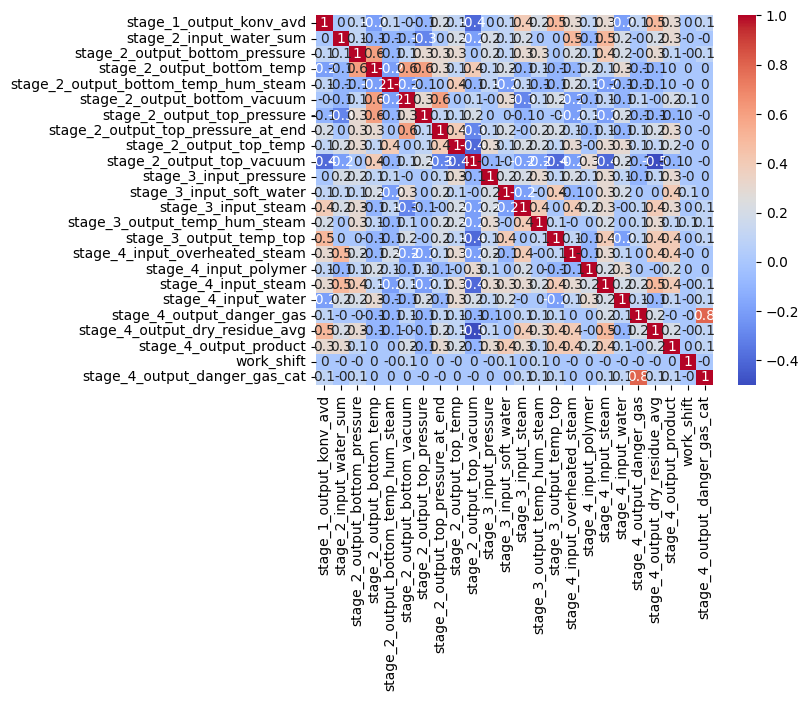

In [25]:
corr_matrix = df[numeric_columns].corr().round(1)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

На большой процент сухого остатка влияет:

*   большой процент конверсии сырья в мономер
*   мало вакуума верха на 2 стадии
*   много подаваемого пара на 3 стадии
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии

На большую массу готового продукта влияют:

*   большая подача смягчённой воды
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии